# Data Exploration

We will now explore the data and try to gain some biological insight from it. 

**Before the starting the Tutors will give an introduction, if you are ready for this step please let them know!**

The dataset we will work with consists of a time-lapse data of a micro-colony of *E. coli* cells growing on LB agar pads. Images were taken every 5min.

We have two channels: phase contrast and GFP. The GFP signal comes from a transcriptional reporter for Colicin Ib, a bacteriocin that is regulated by SOS-stress response.

More info on the data can be found [here](https://doi.org/10.1016/j.cels.2018.03.009).

---

## Import packages

Before starting the code we need to import all the required packages.

We use a number of important Python packages:
- [Numpy](https://numpy.org): Goto package for vector/matrix based calculations (heavily inspired by Matlab)
- [Pandas](https://pandas.pydata.org): Goto package for handling data tables (heavily inspired by R) 
- [Matplotlib](https://matplotlib.org): Goto package for plotting data
- [Seaborn](https://seaborn.pydata.org): Fancy plots made easy (Similar to ggplot in R)
- [pathlib](https://docs.python.org/3/library/pathlib.html): Path handling made easy
- [pickle](https://docs.python.org/3/library/pickle.html): Read pkl file format
- [delta](https://delta.readthedocs.io/en/latest/usage/analysis.html): Delta pipeline

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns

import pathlib
import pickle

import delta

---

## Setup Folders
As always we start with specifying the data paths:

In [2]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'I2ICourse', 'Project2B')
processed_dir = proj_dir / 'ProcessedData'
image_dir = proj_dir / 'RawData'

---

## Some Useful functions

Here are some of the function from the previous notebook we might still like to use.

In [3]:
def to_str(posixpath):
    return str(posixpath.resolve())    

In [4]:
def plot_spatial_map(pos, lin, property, frame=-1, axis=None):
   #pos: delta position object
   #lin: delta linage object
   #property: key of cell property contained in lineage object
   #frame: frame to show, if not specified last one is chosen
   #axis: axis to add plot to, if not specified new one is made
   
   #create color map where Nan is shown as black  
   colMap = cm.get_cmap("viridis").copy()
   colMap.set_bad(color='black')
   
   #get frame
   frame = len(pos.rois[0].label_stack)-1 if frame==-1 else frame

   # get label image:
   labels = pos.rois[0].label_stack[frame]

   spatial_map = np.full(labels.shape, np.nan)

   # Go over cells in selected frame:
   for cnb in lin.cellnumbers[frame]:
   
      #convert to numpy to allow for advanced indexing
      cell_frames = np.array(lin.cells[cnb]['frames'])
      cell_prop = np.array(lin.cells[cnb][property])
   
      #frame index      
      fr_idx = cell_frames==frame
      cell_prop = cell_prop[fr_idx]
      
      #assign cells mask area the phenotype of choice
      spatial_map[labels==cnb+1] = cell_prop

   #create new axis if needed
   if axis is None:
      fig, axis = plt.subplots()
   
   #make plot
   axis.imshow(spatial_map, cmap=colMap)
   axis.set_xlabel('x-pos') 
   axis.set_ylabel('y-pos') 
   axis.set_title(property)
   
   return None

---

## Load Data
We load the data from the last notebook;

In [5]:
#postion object
pos_name = to_str(processed_dir / 'Position000000.pkl')
pos = delta.pipeline.Position(None,None,None)
pos.load(pos_name)

In [8]:
# load the linage objetc:
lin_name = processed_dir / pos_name.replace('.pkl','_updated_lin.pkl')
filehandler = open(lin_name, 'rb') 
lin_obj = pickle.load(filehandler)

In [9]:
#load data frame
df_name = processed_dir / pos_name.replace('.pkl','_df.pkl')
df = pd.read_pickle(df_name)

In [11]:
#export to csv (if needed)
csv_name = processed_dir / pos_name.replace('.pkl','_df.csv')
df.to_csv(csv_name)

---

## A bit more Pandas

For how to use Pandas, please refer to the Project 2A notebook.

Here we just give one last example. Sometime you might be interested in the property of a cell at birth or division. For that Pandas has a very neat function: just combine `groupby` to group cells based on their unique `id_cell` with `first` or `last` to extract the first or last entry of each cell.

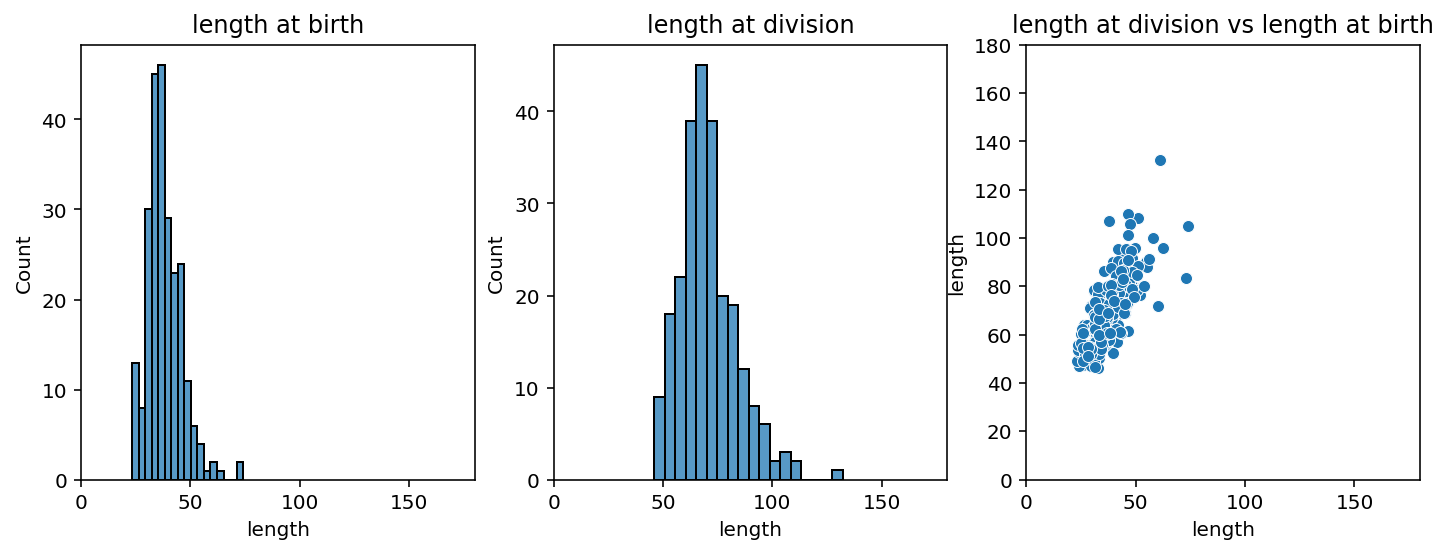

In [12]:
import seaborn as sns

#get first and last frame of all cells
df_first_frame = df.groupby('id_cell').first()
df_last_frame = df.groupby('id_cell').last()

#we only want cells of which we have observed the full lineage
#and exclude the ones that have no offspring (id_d1=-1)
#we can filter these out with:
df_first_frame = df_first_frame.loc[df_first_frame['id_d1']>0]
df_last_frame = df_last_frame.loc[df_last_frame['id_d1']>0]

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_first_frame, x='length', )
sns.histplot(ax=axs[1], data=df_last_frame, x='length')
sns.scatterplot(ax=axs[2], x=df_first_frame['length'], y=df_last_frame['length'])

for ax in axs: ax.set(xlim=(0,180)) 
axs[2].set(ylim=(0,180))

titles = ['length at birth', 'length at division', 'length at division vs length at birth'] 
for idx, title in enumerate(titles): axs[idx].set_title(title)

---

## Exercise

Now it is time for some biology. Discuss with your tutor want kind of biological questions you could address with this data.  
Some ideas:
- Does the phenotype of cells depend on the position in the colony? or on time?
- Are there any correlations between the phenotypes of nearby cells?
- Are there any correlations between the phenotypes of closely related cells?
- Are there correlations between different cell properties (growth rate, fluorescence, size, etc)?
- etc

Above we referred to cell phenotypes. This is any property of interest of the cell. Obvious choices are fluorescent intensity and cell size, for example. But also growth rate is very important, however Delta does not calculate this by default.  
There might also be other interesting phenotypes that Delta does not calculate by default, for example:
- Cell division interval 
- Cell elongation rate (rate at which cell length increases)
  - Hint: cell length is described by $l(t) = l(0) \cdot e^{r\cdot t}$ where $r$ is the elongation/growth rate
  - Hint: elongation rates can change during the life of a cell, how could you quantify this?
- Promoter activity (rate at which fluorescence increases):
  - Hint the promoter activity can be estimated as: $(r + \gamma) \cdot M + \frac{dM}{dt}$, where $r$ is the elongation rate, M the fluorescent intensity of a cell, $\gamma\approx 0.0015$ 1/min the degradation rate of the GFP, and $\frac{dM}{dt}$ is the rate at which the fluorescent intensity of a cell changes in time (for derivation see [here](https://doi.org/10.1126/science.1208144)) 
- etc.

Think about how you could estimate these quantities from the data you do have. 

In [9]:
#Add your code here